Travail réalise par Muthulingam Aginth

# <center><u><font color='red'>Projet 5 : Segmentez des clients d'un site e-commerce</font></u></center>

## Chargement des modules

In [583]:
import pandas as pd
import numpy as np
import random
import re
import seaborn as sns
import plotly
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
import datetime
from sklearn.impute import KNNImputer 
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV , cross_validate
from sklearn.compose import make_column_selector, make_column_transformer , ColumnTransformer 
from category_encoders import *
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn import linear_model , metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor

from sklearn.neighbors import NearestNeighbors
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error , mean_absolute_error, r2_score , davies_bouldin_score , silhouette_score


import plotly.graph_objects as go
import plotly.offline as pyo

## Importation du dataset

In [564]:
df_clean = pd.read_csv('dataset_cleane.csv')

In [565]:
df_clean

,price,nb_purchase,customer_city,customer_state,order_date,shop_days,shop_hours,delivery_time,difference_delivery,payment_installments,...,Maison,Mode,Securite,recency,frequency,monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
0,129.90,1,cajamar,SP,2018-05-10 10:56:27.000000000,3,10,153.869444,-120.0,8,...,True,False,False,2664.0,1.0,129.90,76.17,49.88,71.18,3.30
1,18.90,1,osasco,SP,2018-05-07 11:11:27.000000000,0,11,78.854167,-120.0,1,...,False,False,False,2736.0,1.0,18.90,75.14,49.88,5.10,1.41
2,69.00,1,sao jose,SC,2017-03-10 21:05:03.000000000,4,21,617.562222,-48.0,8,...,False,False,False,12888.0,1.0,69.00,3.42,49.88,43.25,1.96
3,25.99,1,belem,PA,2017-10-12 20:29:41.000000000,3,20,480.890000,-288.0,4,...,False,False,False,7704.0,1.0,25.99,28.70,49.88,11.41,1.24
4,180.00,1,sorocaba,SP,2017-11-14 19:45:42.000000000,1,19,315.387222,-192.0,6,...,False,False,False,6912.0,1.0,180.00,33.80,49.88,83.20,3.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91448,680.00,1,sanharo,PE,2017-06-08 21:00:36.000,3,21,660.356667,-648.0,10,...,False,False,False,10728.0,1.0,680.00,12.08,49.88,98.05,3.58
91449,64.89,1,feira de santana,BA,2017-12-10 20:07:56.000,6,20,722.340000,-72.0,1,...,False,False,False,6288.0,1.0,64.89,41.52,49.88,41.08,2.18
91450,89.90,1,sinop,MT,2017-02-07 15:49:16.000,1,15,356.930000,-720.0,1,...,False,False,False,13632.0,1.0,89.90,1.46,49.88,54.69,2.27
91451,115.00,1,bom jesus do norte,ES,2018-05-02 15:17:41.000,2,15,284.612500,-336.0,5,...,False,True,False,2856.0,1.0,115.00,73.79,49.88,65.84,3.13


In [566]:
df_clean = df_clean.drop(['customer_city','order_date'],axis=1)

## Transformation

In [427]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

categorical_columns = df_clean.select_dtypes(include=['object']).columns
numerical_columns = df_clean.select_dtypes(include=['int64','float64']).columns
bool_columns = df_clean.select_dtypes(include=['bool']).columns


ohe = OneHotEncoder(sparse=False)
ss = StandardScaler()
df_clean[numerical_columns] = ss.fit_transform(df_clean[numerical_columns])
ohe.fit(df_clean[categorical_columns])

OneHotEncoder(sparse=False)

In [428]:
X = pd.merge(df_clean[numerical_columns], 
          pd.DataFrame(columns = ohe.get_feature_names().tolist(),
              data = ohe.fit_transform(df_clean[categorical_columns])).set_index(df_clean.index),
        left_index = True, right_index = True)

In [429]:
df_clean[bool_columns]= df_clean[bool_columns].astype(int)

In [430]:
Xf = pd.merge(X,df_clean[bool_columns],left_index = True, right_index = True)

In [431]:
Xf.drop(columns=['R_rank_norm','F_rank_norm','M_rank_norm','price','nb_purchase'], inplace=True)

Xf

,shop_days,shop_hours,delivery_time,difference_delivery,payment_installments,payment_sequential,review_score,answers_time,review_lenght,recency,...,payment_type_credit_card,Alimentation,Autres,Bricolage,Electronique/Electromenager,Hygiene,Loisirs,Maison,Mode,Securite
0,0.131035,-0.903846,-0.646371,0.684553,1.909414,-0.121252,0.660534,0.144163,1.772506,-0.833292,...,1,0,0,0,0,0,0,1,0,0
1,-1.394111,-0.714874,-0.976988,0.684553,-0.703693,-0.121252,-0.121429,-0.226109,-0.552042,-0.813598,...,1,0,0,0,0,1,0,0,0,0
2,0.639418,1.174837,1.397272,0.982522,1.909414,-0.121252,-0.903392,-0.214063,-0.552042,1.963339,...,1,0,0,0,0,0,1,0,0,0
3,0.131035,0.985866,0.794914,-0.010710,0.416210,-0.121252,-0.121429,-0.218440,-0.419211,0.545329,...,1,0,0,0,1,0,0,0,0,0
4,-0.885729,0.796895,0.065490,0.386583,1.162812,-0.121252,0.660534,0.181279,-0.552042,0.328688,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91448,0.131035,1.174837,1.585881,-1.500558,2.656016,-0.121252,0.660534,0.133928,-0.552042,1.372501,...,1,0,0,0,0,1,0,0,0,0
91449,1.656182,0.985866,1.859062,0.883199,-0.703693,-0.121252,-0.121429,0.238028,-0.552042,0.158002,...,1,0,0,0,0,1,0,0,0,0
91450,-0.885729,0.041010,0.248582,-1.798528,-0.703693,-0.121252,0.660534,-0.053969,-0.552042,2.166850,...,1,0,1,0,0,0,0,0,0,0
91451,-0.377347,0.041010,-0.070144,-0.209356,0.789511,-0.121252,0.660534,-0.053051,2.259554,-0.780774,...,1,0,0,0,0,0,0,0,1,0


In [432]:
state_columns=['x0_AC', 'x0_AL', 'x0_AM', 'x0_AP', 'x0_BA', 'x0_CE', 'x0_DF', 'x0_ES',
       'x0_GO', 'x0_MA', 'x0_MG', 'x0_MS', 'x0_MT', 'x0_PA', 'x0_PB', 'x0_PE',
       'x0_PI', 'x0_PR', 'x0_RJ', 'x0_RN', 'x0_RO', 'x0_RR', 'x0_RS', 'x0_SC',
       'x0_SE', 'x0_SP', 'x0_TO']

## ACP

In [433]:
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import decomposition
from sklearn.decomposition import PCA
pca = PCA(random_state=1)

In [434]:
X_pca = Xf.copy()#.drop([*state_columns,*bool_columns],axis=1)

In [435]:
X_pca.columns

Index(['shop_days', 'shop_hours', 'delivery_time', 'difference_delivery',
       'payment_installments', 'payment_sequential', 'review_score',
       'answers_time', 'review_lenght', 'recency', 'frequency', 'monetary',
       'RFM_Score', 'x0_AC', 'x0_AL', 'x0_AM', 'x0_AP', 'x0_BA', 'x0_CE',
       'x0_DF', 'x0_ES', 'x0_GO', 'x0_MA', 'x0_MG', 'x0_MS', 'x0_MT', 'x0_PA',
       'x0_PB', 'x0_PE', 'x0_PI', 'x0_PR', 'x0_RJ', 'x0_RN', 'x0_RO', 'x0_RR',
       'x0_RS', 'x0_SC', 'x0_SE', 'x0_SP', 'x0_TO', 'payment_type_boleto',
       'payment_type_debit_card', 'payment_type_voucher',
       'payment_type_credit_card', 'Alimentation', 'Autres', 'Bricolage',
       'Electronique/Electromenager', 'Hygiene', 'Loisirs', 'Maison', 'Mode',
       'Securite'],
      dtype='object')

In [436]:
pca.fit(X_pca)

PCA(random_state=1)

In [437]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

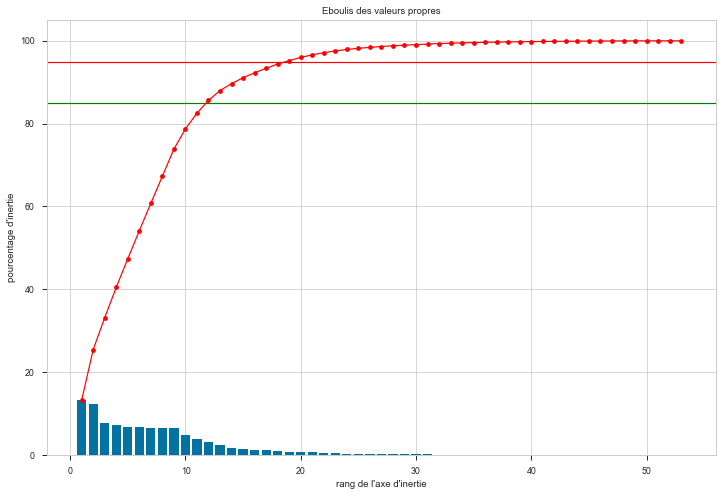

In [438]:
# Eboulis des valeurs propres
plt.figure(figsize=(12,8))
plt.axhline(y=95,color='red')
plt.axhline(y=85,color='green')
display_scree_plot(pca)

In [439]:
print(pca.explained_variance_ratio_.cumsum())

[0.1321277  0.25458528 0.33152153 0.40492245 0.4737116  0.54149472
 0.6077004  0.67320848 0.73829875 0.78757971 0.82527278 0.85610204
 0.87988898 0.89662465 0.9109746  0.92272118 0.93363345 0.94406637
 0.95212914 0.95980319 0.966273   0.9714482  0.97555115 0.97908302
 0.98189111 0.98419617 0.98623503 0.98801466 0.98942759 0.99083019
 0.992181   0.9933173  0.99425364 0.99501812 0.99572334 0.99634971
 0.99688654 0.99737849 0.99776313 0.99810808 0.99843842 0.9987226
 0.99896555 0.99918521 0.99938301 0.99955115 0.99969125 0.99979514
 0.99986683 0.99992299 0.99997148 1.         1.        ]


In [440]:
# Fonction permettant le tracé des cercle de correlations

from matplotlib.patches import Circle

def display_circle (pca_components_,ls_comp,col_pca) :
    
    comp1 = ls_comp[0]
    comp2= ls_comp[1]
    sns.set_context("paper", font_scale=1.5) 
    plt.figure(figsize=(14,14))
    chaine = "Plan factoriel pour les composantes "+str(comp1+1)+" & "+str(comp2+1)+" de l'ACP"
    plt.title(chaine)
    x_lab = 'Composante '+str(comp1+1) ; y_lab = 'Composante '+str(comp2+1)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    ax = plt.gca()
    ax.add_patch(Circle([0,0], radius=1, color='black', fill=False, linestyle='-'))
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    x_pca = pca_components_[comp1,:]
    y_pca = pca_components_[comp2,:]

    sns.scatterplot(x = x_pca, y = y_pca)
    plt.plot([-1,1],[0,0], color='grey')
    plt.plot([0,0],[-1,1], color='grey')

    i = 0
    for x,y,colonne in zip(x_pca,y_pca, col_pca):

        plt.annotate(colonne, (x,y), textcoords="offset points", xytext=(0,5+np.random.randint(-10,10)), ha='center') 
        ax.arrow(0, 0, x, y, head_width=0, head_length=0, fc='grey', ec='grey',alpha=0.2)


    sns.set_context("paper", font_scale=1) 
    
    return 

def display_factorial_plane (data_pca,col_pca,pca_components_,ls_comp) :
    comp1 = ls_comp[0]
    comp2 = ls_comp[1]
    
    x_show = pca.transform(data_pca[col_pca])[:,comp1]
    y_show = pca.transform(data_pca[col_pca])[:,comp2]
    hue_show = data_pca['nutrigrade']
    
    sns.set_context("paper", font_scale=1.5) 
    plt.figure(figsize=(14,14))
    chaine = "Plan factoriel pour les composantes "+str(comp1+1)+" & "+str(comp2+1)+" de l'ACP"
    plt.title(chaine)
    x_lab = 'Composante '+str(comp1+1) ; y_lab = 'Composante '+str(comp2+1)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    ax = plt.gca()

    ax.set_xlim(-1000,1000)
    ax.set_ylim(-1000,1000)
    x_pca = pca.components_[comp1,:]*500
    y_pca = pca.components_[comp2,:]*500

    sns.scatterplot(x = x_pca,y = y_pca)
    sns.scatterplot(x = x_show,y = y_show,hue = hue_show, s=20)
    plt.plot([-1,1],[0,0], color='grey')
    plt.plot([0,0],[-1,1], color='grey')

    i = 0
    for x,y,colonne in zip(x_pca,y_pca, col_pca):

        plt.annotate(colonne,(x,y),textcoords="offset points",xytext=(0,5+np.random.randint(-10,10)),ha='center')
        ax.arrow(0, 0, x, y, head_width=0, head_length=0, fc='grey', ec='grey',alpha=0.2)


    sns.set_context("paper", font_scale=1) 

    return

In [441]:
col_pca=X_pca.select_dtypes(include=['int64','float64']).columns

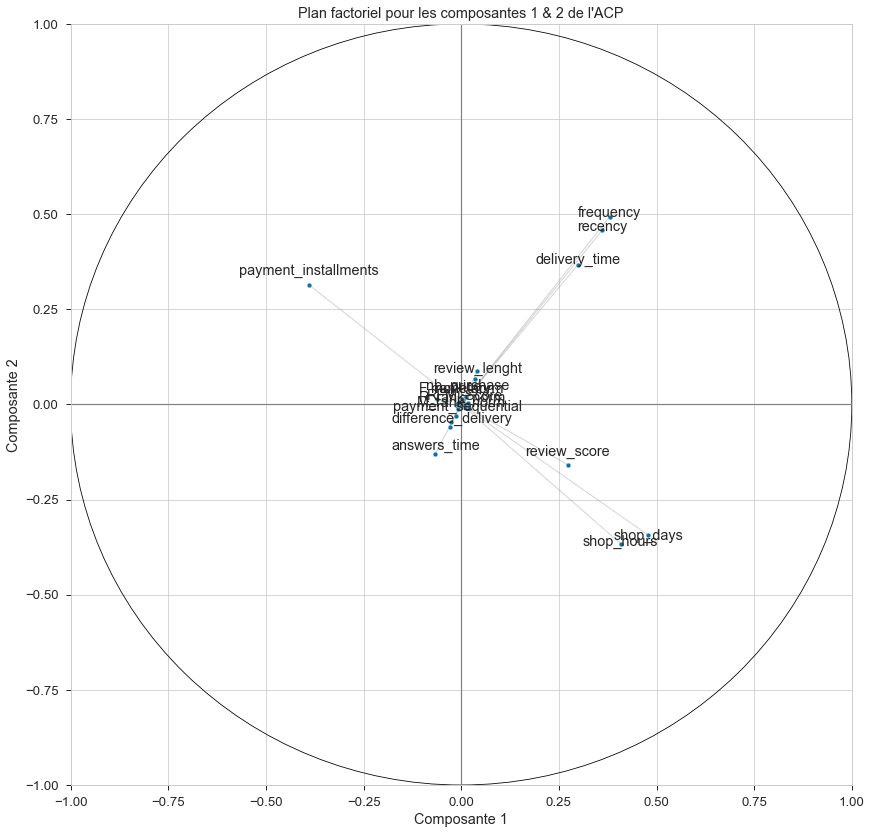

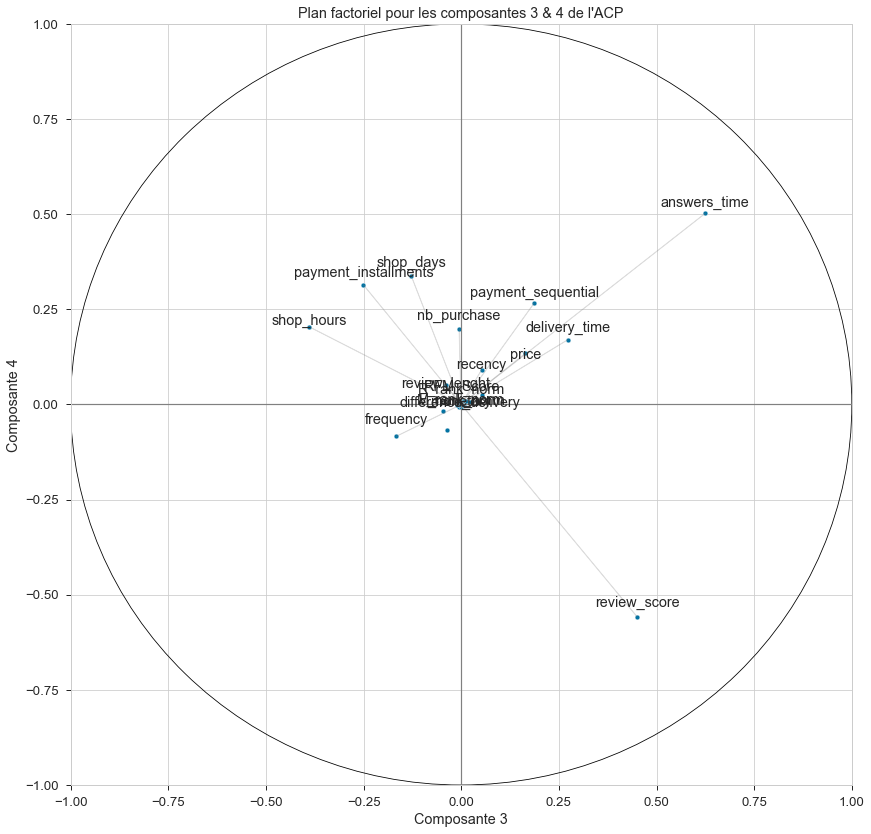

In [442]:
#Cercle des corrélations
pcs = pca.components_
ls_comp =  [(0,1),(2,3)]
for i in ls_comp :
    display_circle(pcs,i,numerical_columns)

In [443]:
X_pca = pca.transform(X_pca)[:, :19]

In [444]:
X_pca

array([[ 1.14693851,  1.20077227,  0.36633431, ..., -0.10999033,
        -0.12699171, -0.01655608],
       [-1.1847907 , -0.8623313 , -1.15781025, ...,  0.12400675,
         0.87802399, -0.05881179],
       [ 1.42128582, -1.01127355,  1.33623217, ...,  0.65732787,
        -0.46246684,  0.06045487],
       ...,
       [-1.51490449,  0.14097819,  1.33118356, ...,  0.00764723,
         0.1029956 ,  0.13921859],
       [ 0.82961363,  0.71584242,  0.50519832, ..., -0.06047998,
        -0.01610931,  0.0557289 ],
       [-1.21785132,  0.0269016 ,  0.91809307, ..., -0.03788935,
         0.83412511, -0.03969107]])

## Clustering

In [445]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

In [446]:
X_pca.shape

(91453, 19)

In [447]:
tsne = TSNE(n_components=2, init='pca')
X_tsne = tsne.fit_transform(X_pca)
columns = ['DIM' + str(c) for c in range(1, X_tsne.shape[1]+1, 1)]
X_tsne = pd.DataFrame(X_tsne, columns=columns) #, index=X.index
X_tsne.head()

,DIM1,DIM2
0,26.058661,-0.012988
1,-37.459072,10.768032
2,24.342150,12.850627
3,-18.882116,-5.354738
4,-1.380095,32.840786


In [448]:
ls_comp=[]
for i in range(1,X_pca.shape[1]+1):
    comp='Component '+str(i)
    ls_comp.append(comp)

df_pca = pd.DataFrame(X_pca,columns=ls_comp)
df_pca

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,Component 11,Component 12,Component 13,Component 14,Component 15,Component 16,Component 17,Component 18,Component 19
0,1.146939,1.200772,0.366334,-1.186446,-0.407761,0.364841,-0.066598,-0.693852,-0.068676,-1.411266,1.789328,0.707998,-0.574026,0.496899,0.523815,-0.068156,-0.109990,-0.126992,-0.016556
1,-1.184791,-0.862331,-1.157810,-0.822759,0.111255,0.970187,-0.630333,0.288437,-0.346558,-0.582092,-0.322408,1.188636,0.366172,-0.380692,-0.133164,-0.023114,0.124007,0.878024,-0.058812
2,1.421286,-1.011274,1.336232,2.341267,-0.773331,-0.655474,0.332438,0.918464,-0.421774,-1.096890,-0.431920,0.079520,-0.117016,0.068197,-0.614637,-0.147629,0.657328,-0.462467,0.060455
3,-0.306571,-1.129293,0.426478,1.065840,-0.528786,-0.512740,0.073998,0.788640,-0.007416,-0.607261,-0.180713,-0.302482,0.986499,-0.119306,-0.230749,0.386626,-0.495907,-0.286800,0.039708
4,0.529899,1.122909,-0.314424,0.966755,-0.109204,0.038093,-0.889585,0.813444,-0.028364,-0.533178,0.294073,0.355840,-0.444280,-0.073414,-0.342580,0.660444,-0.721473,-0.437508,-0.033046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91448,2.011728,3.068995,1.553744,2.358813,-0.219838,-0.526251,-0.326348,0.774047,-0.563285,0.279192,-0.115391,-0.987083,1.045477,0.232099,-0.136222,0.931135,0.361361,0.825200,0.084924
91449,0.746570,-1.487732,-0.513978,1.560635,-0.590432,-1.122815,0.855284,-0.452641,0.703990,0.404395,-0.008042,-0.617887,0.195051,-0.529742,-0.107717,0.288622,0.133036,0.882977,0.086432
91450,-1.514904,0.140978,1.331184,1.113330,0.444574,0.664875,-0.365250,0.920532,-0.755411,0.900736,-0.295059,-1.154714,-0.255554,-0.672359,0.083774,0.383576,0.007647,0.102996,0.139219
91451,0.829614,0.715842,0.505198,-1.469895,-0.142644,-0.033296,-0.423590,0.174612,0.286705,-0.456171,1.796117,-0.650227,0.013268,-0.133557,-0.204151,-0.092846,-0.060480,-0.016109,0.055729


In [449]:
#Sampling 
df_pca_sample=df_pca.copy().sample(n = 20000)

In [450]:
X_tsne_sample = X_tsne.copy().loc[df_pca_sample.index]

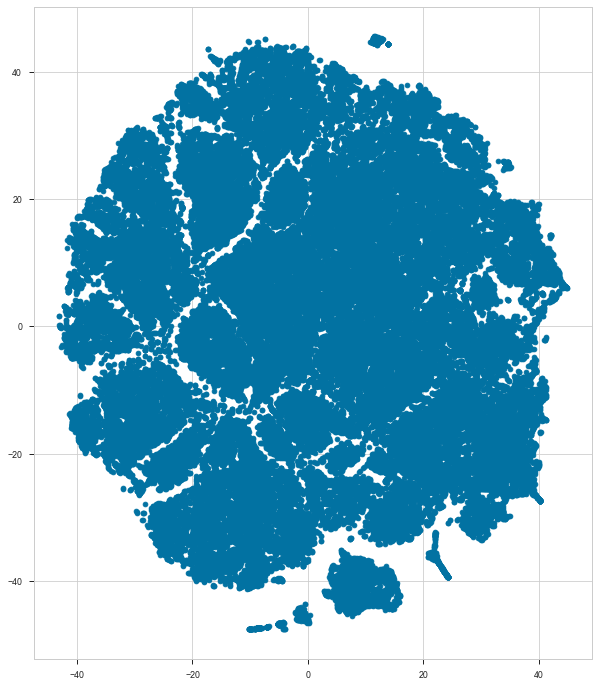

In [451]:
plt.figure(figsize=(10,12))
plt.scatter(X_tsne.copy()['DIM1'],X_tsne.copy()['DIM2'])

### <font color='blue'>Kmeans

#### Distorsion

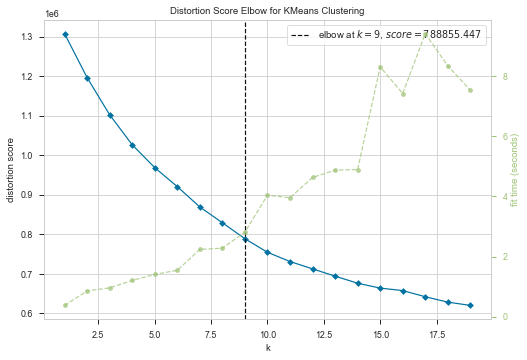

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [452]:
# distorsion
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))

visualizer.fit(df_pca)        # Fit the data to the visualizer
visualizer.show() 

#### Silhouette

In [453]:
silhouettes_kmeans=dict()
indiceDB_kmeans=dict()
for k in range(2, 11):
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=k).fit(df_pca.copy())
    clusters = kmeans.labels_
    
    silhouettes_kmeans[k] = silhouette_score(df_pca.copy(), clusters)
    indiceDB_kmeans[k] = davies_bouldin_score(df_pca.copy(), clusters)

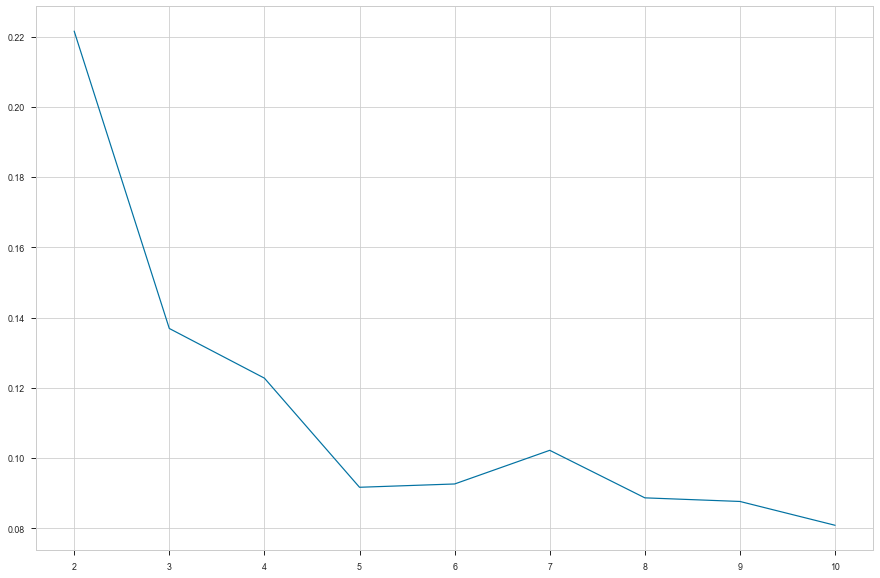

In [454]:
plt.figure(figsize=(15, 10))
plt.plot(
    list(silhouettes_kmeans.keys()), list(silhouettes_kmeans.values()))

#### Indice de David Bouldin

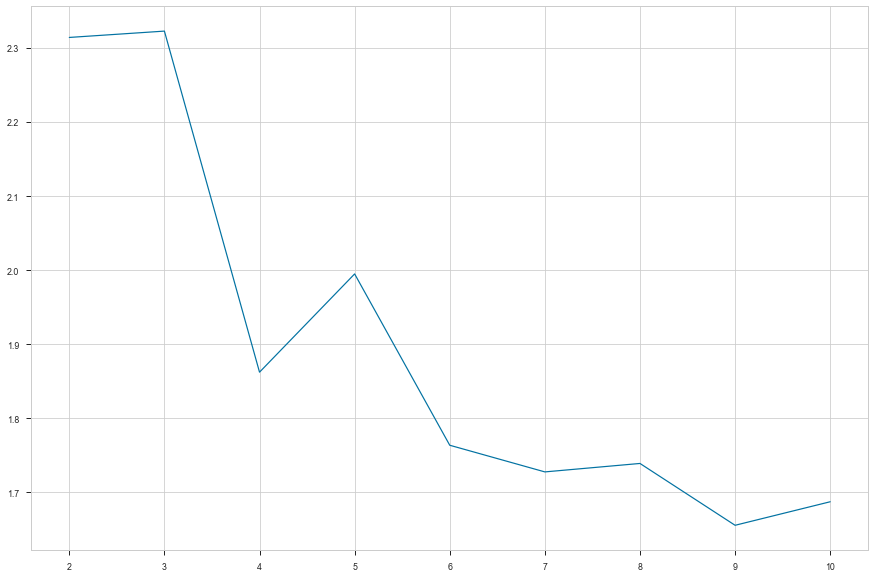

In [455]:
plt.figure(figsize=(15, 10))
plt.plot(
    list(indiceDB_kmeans.keys()), list(indiceDB_kmeans.values()))

#### Representation

In [1]:
km = KMeans(n_clusters=4).fit(df_pca.copy())
km_labels=km.labels_

NameError: name 'KMeans' is not defined

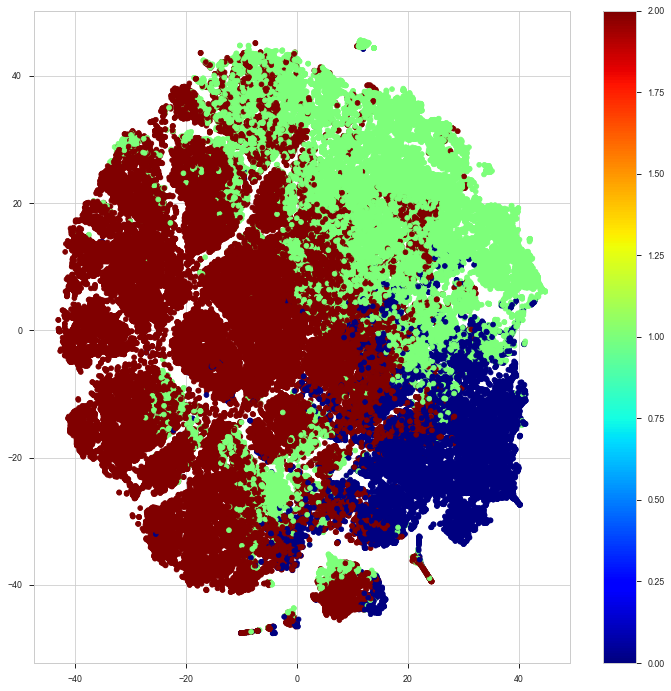

In [607]:
plt.figure(figsize=(12,12))
plt.scatter(X_tsne.copy()['DIM1'],X_tsne.copy()['DIM2'],c=km_labels,cmap=plt.cm.jet)
plt.colorbar()

### <font color='blue'>DBScan

In [461]:
db = DBSCAN(eps=0.5, min_samples=5).fit(df_pca)
db_labels = db.labels_

In [462]:
import collections
counter = collections.Counter(db_labels)
counter

Counter({-1: 91388,
         6: 5,
         5: 5,
         2: 5,
         4: 8,
         8: 6,
         9: 5,
         0: 5,
         3: 6,
         11: 5,
         1: 5,
         10: 5,
         7: 5})

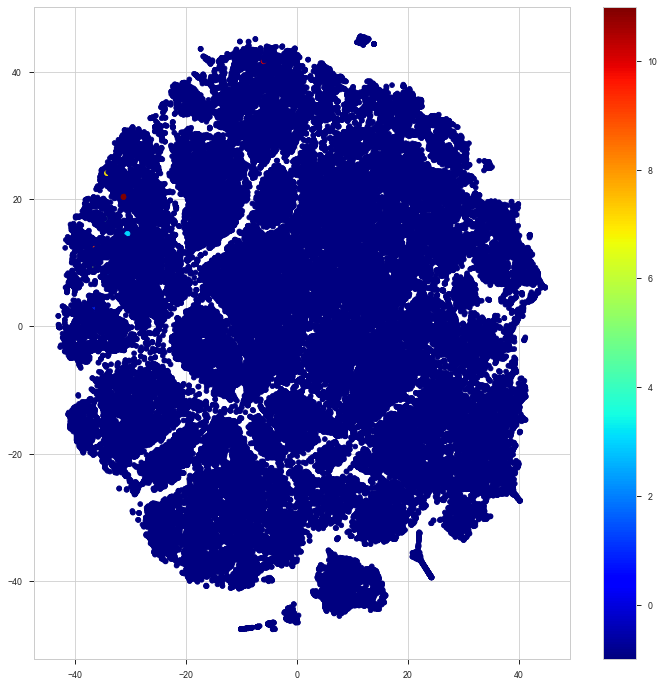

In [463]:
plt.figure(figsize=(12,12))
plt.scatter(X_tsne['DIM1'],X_tsne['DIM2'],c=db_labels,cmap=plt.cm.jet)
plt.colorbar()

### <font color='blue'>Clustering hierachique

#### Distorsion

In [464]:
cah = AgglomerativeClustering()

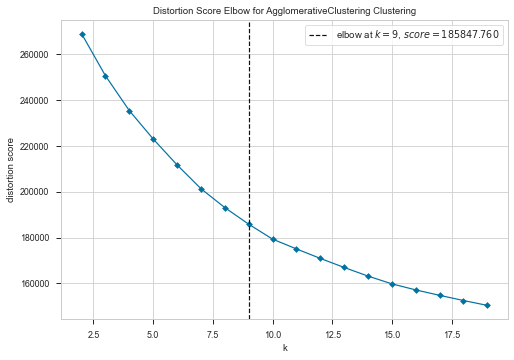

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [465]:
visualizer = KElbowVisualizer(cah, k=(2,20), timings=False)
visualizer.fit(df_pca_sample)        # Fit the data to the visualizer
visualizer.show() 

#### Silhouette

In [466]:
silhouettes_cah=dict()
indiceDB_cah=dict()
for k in range(2, 11):
    # seed of 10 for reproducibility.
    CAH = AgglomerativeClustering(n_clusters=k).fit(df_pca_sample.copy())
    CAH_labels = CAH.labels_
    
    silhouettes_cah[k] = silhouette_score(df_pca_sample.copy(), CAH_labels)
    indiceDB_cah[k] = davies_bouldin_score(df_pca_sample.copy(), CAH_labels)

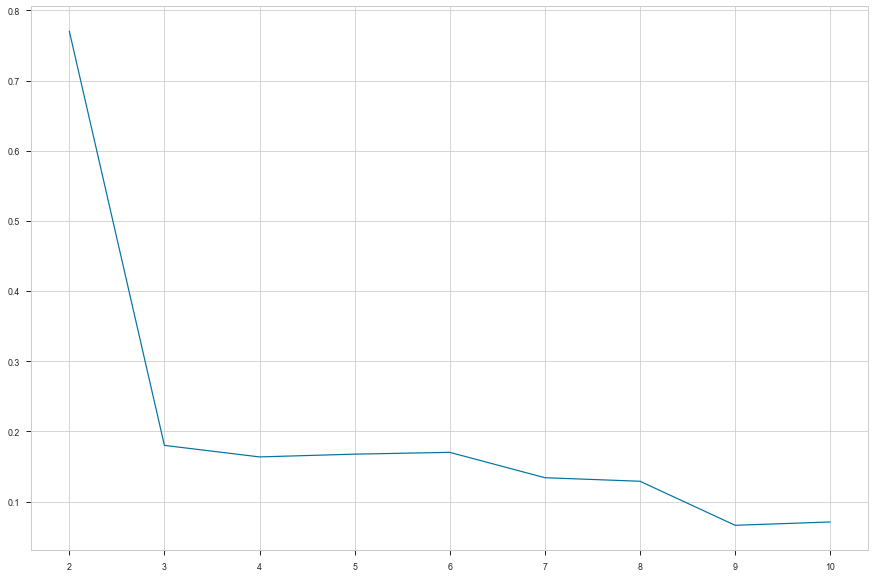

In [467]:
plt.figure(figsize=(15, 10))
plt.plot(
    list(silhouettes_cah.keys()), list(silhouettes_cah.values()))

#### Indice de David Bouldin

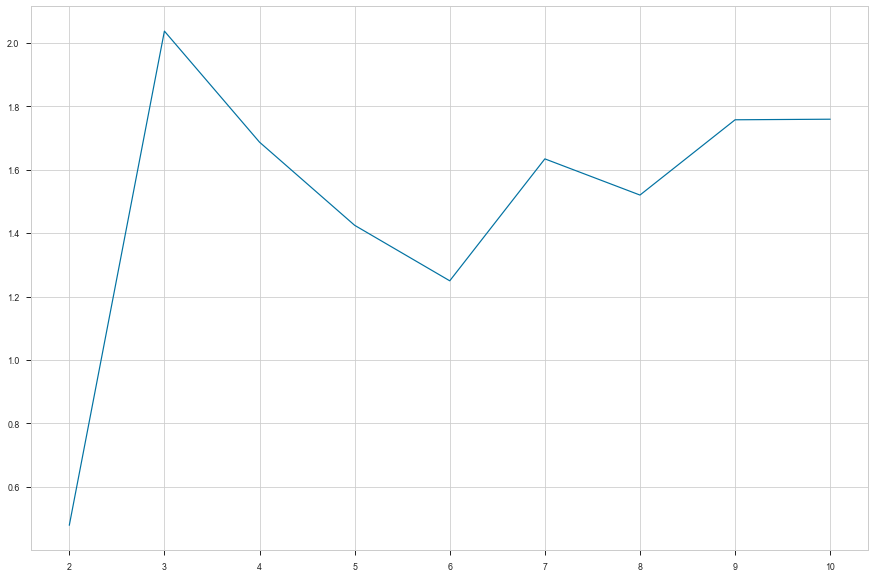

In [468]:
plt.figure(figsize=(15, 10))
plt.plot(
    list(indiceDB_cah.keys()), list(indiceDB_cah.values()))

In [597]:
myclust_ch = AgglomerativeClustering(n_clusters=6).fit(df_pca_sample)

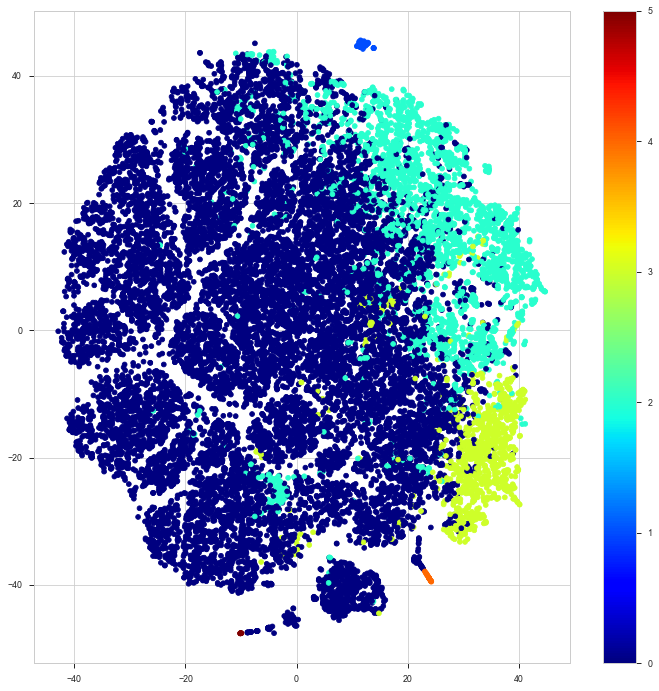

In [598]:
plt.figure(figsize=(12,12))
plt.scatter(X_tsne_sample['DIM1'],X_tsne_sample['DIM2'],c=myclust_ch.labels_,cmap=plt.cm.jet)
plt.colorbar()

In [599]:
counterCAH = collections.Counter(myclust_ch.labels_)
counterCAH

Counter({0: 16087, 2: 2826, 3: 1004, 1: 54, 5: 9, 4: 20})